In [1]:
import scipy.io
import numpy as np
import mne


Load and explore data using the `SubjectData` class.

In [ ]:
from src.data_loader import SubjectData, load_subject, load_all_subjects

# Load subject i01 EMO data
subject_emo = load_subject('i01', 'EMO')
print("\nSummary:")
print(subject_emo.summary())


Summary:
{'subject_id': 'i01', 'condition': 'EMO', 'file_path': 'data/i01/i01_EMO.mat', 'num_phases': 2, 'data_fields': {'EEG_ph': (1, 2), 'Physio_ph': (1, 2), 'RR_ph': (1, 2), 'RRi_ph': (1, 2), 'T_RR_ph': (1, 2), 'T_RRi_ph': (1, 2), 'videos': (1, 3)}, 'num_videos': 3}


In [ ]:
# Load data for analysis
import importlib
import src.data_loader
importlib.reload(src.data_loader)
from src.data_loader import load_subject

# Load subject i01 EMO
subject_emo = load_subject('i01', 'EMO')

# Get EEG as MNE Raw object
eeg_phase0 = subject_emo.get_eeg_data(phase_index=0)

# Get HRV data
rri_phase0 = subject_emo.get_rri_data(phase_index=0)
rri_times = subject_emo.get_timestamps_rri(phase_index=0)

print(f"✓ Loaded subject i01 EMO")
print(f"  EEG: {eeg_phase0.n_times} samples @ {eeg_phase0.info['sfreq']} Hz, {len(eeg_phase0.ch_names)} channels")
print(f"  HRV: {rri_phase0.shape} samples @ 4 Hz")
print(f"  Montage: {subject_emo.get_montage_info()['type']}")


✓ Loaded subject i01 EMO
  EEG: 92515 samples @ 500.0 Hz, 19 channels
  HRV: (1, 741) samples @ 4 Hz
  Montage: custom_eeglab


/Users/zeyad/Documents/projects/brain-heart-microstates-of-emotional-arousal/data_loader.py:267: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations, verbose=False)


## 1. Calculate and Plot EEG Power Spectral Density

Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


/var/folders/17/rqwtx3ln267d3s23tr72t9nh0000gn/T/ipykernel_51527/1344056302.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


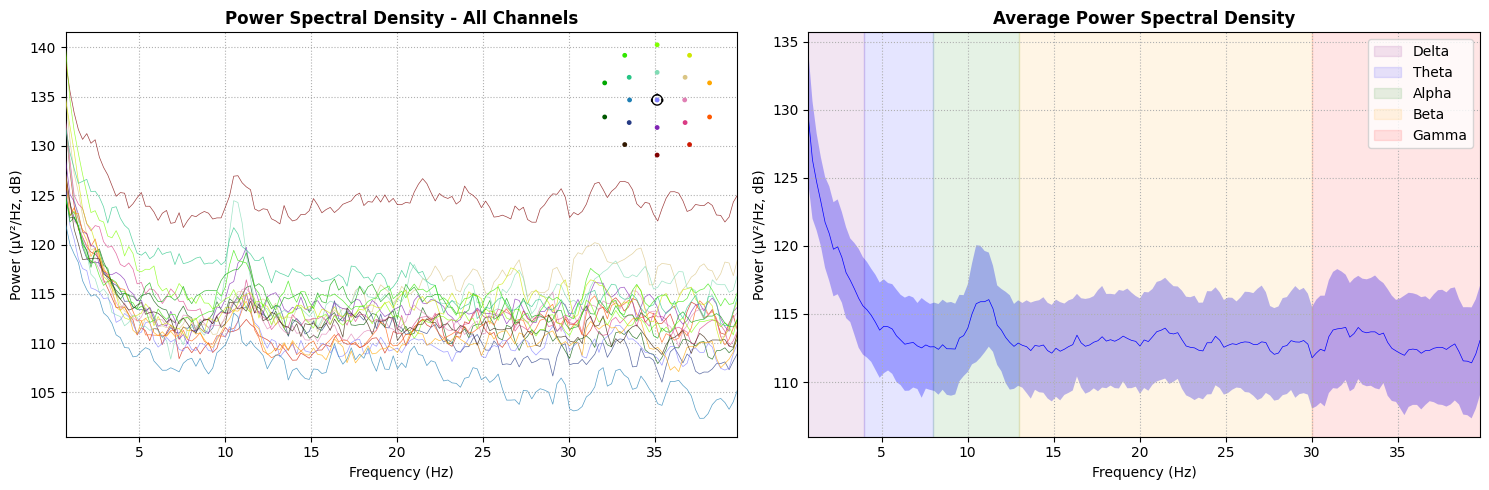


✓ Power spectral density calculated and plotted
  Frequency range: 0.5-40 Hz
  Method: Welch's method with 2048-point FFT


In [26]:
# Calculate power spectral density
import matplotlib.pyplot as plt

# Compute PSD using Welch's method
psd = eeg_phase0.compute_psd(method='welch', fmin=0.5, fmax=40, n_fft=2048, verbose=False)

# Plot PSD for all channels
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: PSD for all channels
psd.plot(axes=axes[0], show=False, average=False, spatial_colors=True)
axes[0].set_title('Power Spectral Density - All Channels', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Power (µV²/Hz, dB)')

# Plot 2: Average PSD across channels
psd.plot(axes=axes[1], show=False, average=True, color='blue')
axes[1].set_title('Average Power Spectral Density', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Power (µV²/Hz, dB)')

# Add frequency band markers
bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 30), 'Gamma': (30, 40)}
colors = ['purple', 'blue', 'green', 'orange', 'red']
for (band_name, (fmin, fmax)), color in zip(bands.items(), colors):
    axes[1].axvspan(fmin, fmax, alpha=0.1, color=color, label=band_name)
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

print("\n✓ Power spectral density calculated and plotted")
print(f"  Frequency range: 0.5-40 Hz")
print(f"  Method: Welch's method with 2048-point FFT")


## 2. Plot Topoplot of Power in Different Frequency Bands

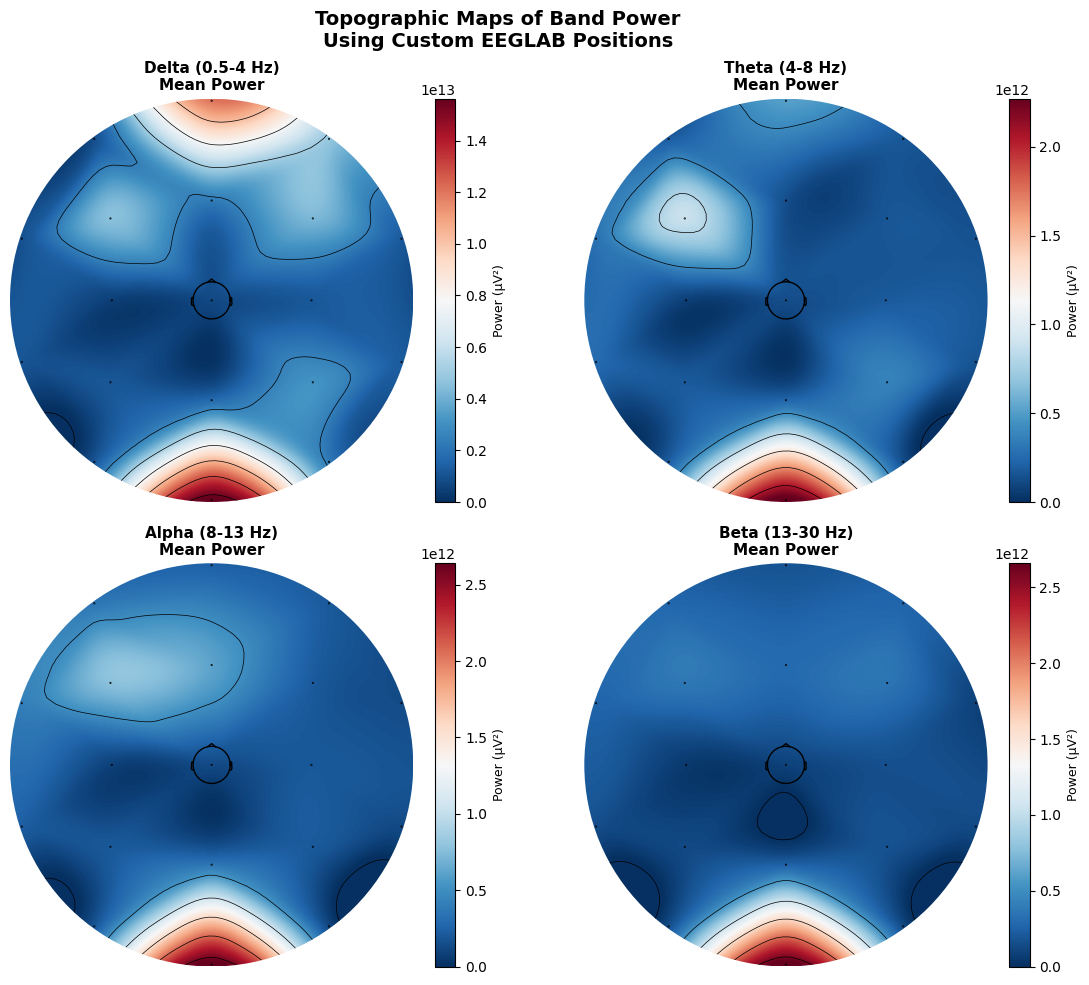


✓ Topoplots created for each frequency band
  Using custom EEGLAB electrode positions
  Bands: Delta, Theta, Alpha, Beta


In [33]:
# Calculate band power and create topoplots
import numpy as np

# Define frequency bands
freq_bands = {
    'Delta (0.5-4 Hz)': (0.5, 4),
    'Theta (4-8 Hz)': (4, 8),
    'Alpha (8-13 Hz)': (8, 13),
    'Beta (13-30 Hz)': (13, 30)
}

# Create figure with subplots for each band
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Get PSD data
psds, freqs = psd.get_data(return_freqs=True)

for idx, (band_name, (fmin, fmax)) in enumerate(freq_bands.items()):
    # Find frequency indices for this band
    freq_mask = (freqs >= fmin) & (freqs <= fmax)
    
    # Calculate mean power in this band for each channel
    band_power = psds[:, freq_mask].mean(axis=1)
    
    # Convert to µV² (from V²)
    band_power_uv = band_power * 1e12
    
    # Create topoplot
    im, cn = mne.viz.plot_topomap(
        band_power_uv,
        eeg_phase0.info,
        axes=axes[idx],
        show=False,
        cmap='RdBu_r',
        contours=6
    )
    axes[idx].set_title(f'{band_name}\nMean Power', fontsize=11, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
    cbar.set_label('Power (µV²)', fontsize=9)

plt.suptitle('Topographic Maps of Band Power\nUsing Custom EEGLAB Positions', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\n✓ Topoplots created for each frequency band")
print(f"  Using custom EEGLAB electrode positions")
print(f"  Bands: Delta, Theta, Alpha, Beta")


## 3. Plot HRV Over Time

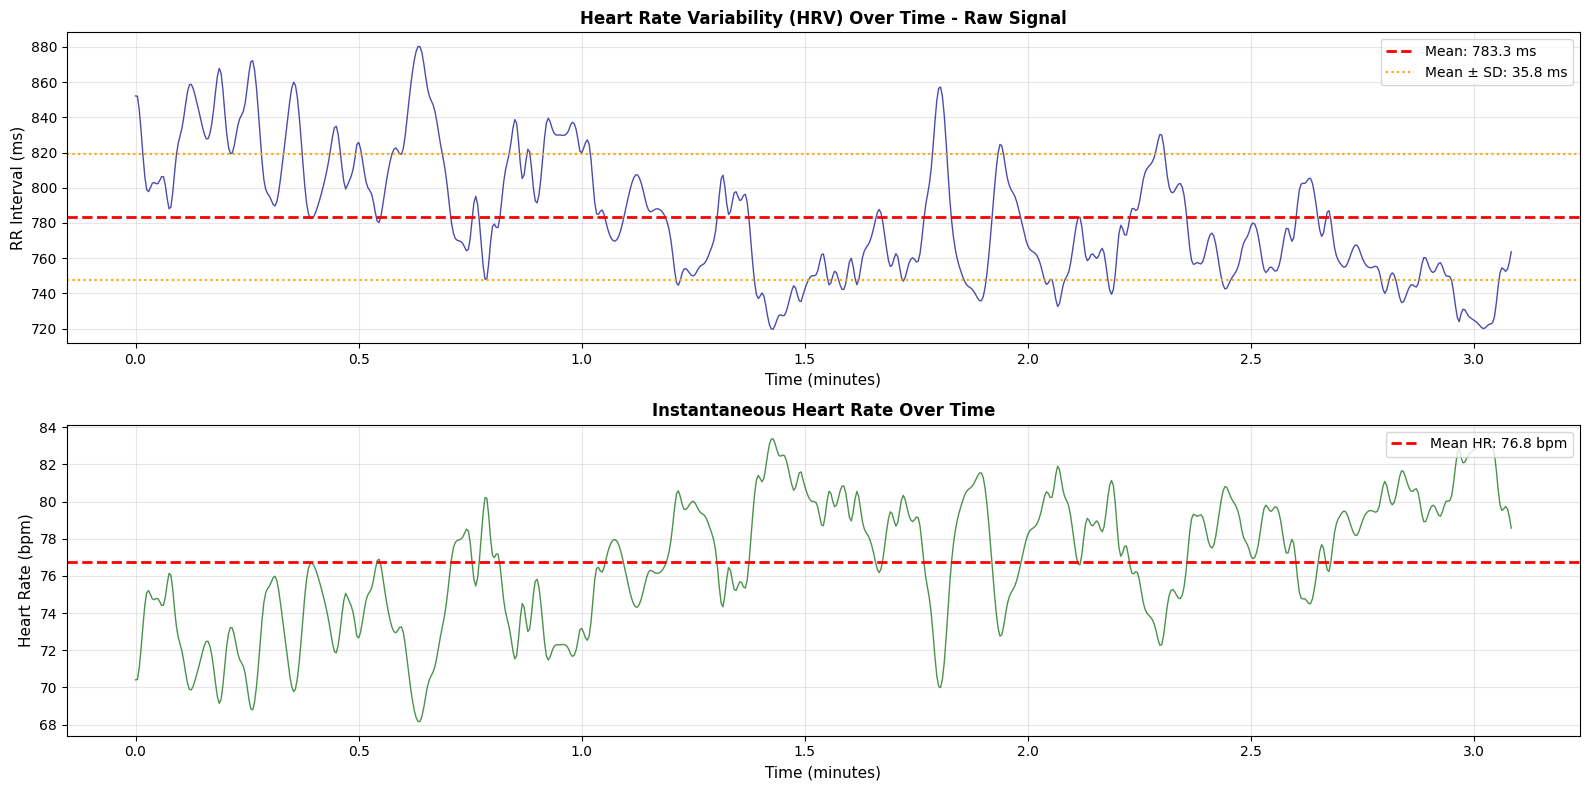


HRV SUMMARY STATISTICS:
Duration: 3.08 minutes (185.0 seconds)
Samples: 741 at 4 Hz

RR Interval:
  Mean: 783.3 ms
  Std:  35.8 ms
  Min:  719.7 ms
  Max:  880.3 ms

Heart Rate:
  Mean: 76.8 bpm
  Std:  3.4 bpm
  Min:  68.2 bpm
  Max:  83.4 bpm


In [29]:
# Plot HRV (RRi) over time
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Extract HRV data (flatten if needed)
hrv_data = rri_phase0.flatten() if rri_phase0.ndim > 1 else rri_phase0
time_data = rri_times.flatten() if rri_times.ndim > 1 else rri_times

# Convert time to minutes for better readability
time_minutes = time_data / 60

# Plot 1: Raw HRV time series
axes[0].plot(time_minutes, hrv_data * 1000, linewidth=1, color='darkblue', alpha=0.7)
axes[0].set_xlabel('Time (minutes)', fontsize=11)
axes[0].set_ylabel('RR Interval (ms)', fontsize=11)
axes[0].set_title('Heart Rate Variability (HRV) Over Time - Raw Signal', 
                   fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Add mean and std lines
mean_hrv = np.mean(hrv_data * 1000)
std_hrv = np.std(hrv_data * 1000)
axes[0].axhline(mean_hrv, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_hrv:.1f} ms')
axes[0].axhline(mean_hrv + std_hrv, color='orange', linestyle=':', linewidth=1.5,
                label=f'Mean ± SD: {std_hrv:.1f} ms')
axes[0].axhline(mean_hrv - std_hrv, color='orange', linestyle=':', linewidth=1.5)
axes[0].legend(loc='upper right')

# Plot 2: Calculate and plot heart rate (inverse of RR interval)
heart_rate = 60 / hrv_data  # Convert RR interval (seconds) to beats per minute
axes[1].plot(time_minutes, heart_rate, linewidth=1, color='darkgreen', alpha=0.7)
axes[1].set_xlabel('Time (minutes)', fontsize=11)
axes[1].set_ylabel('Heart Rate (bpm)', fontsize=11)
axes[1].set_title('Instantaneous Heart Rate Over Time', 
                   fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add mean HR line
mean_hr = np.mean(heart_rate)
axes[1].axhline(mean_hr, color='red', linestyle='--', linewidth=2,
                label=f'Mean HR: {mean_hr:.1f} bpm')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("HRV SUMMARY STATISTICS:")
print("="*70)
print(f"Duration: {time_data[-1]/60:.2f} minutes ({time_data[-1]:.1f} seconds)")
print(f"Samples: {len(hrv_data)} at 4 Hz")
print(f"\nRR Interval:")
print(f"  Mean: {mean_hrv:.1f} ms")
print(f"  Std:  {std_hrv:.1f} ms")
print(f"  Min:  {np.min(hrv_data * 1000):.1f} ms")
print(f"  Max:  {np.max(hrv_data * 1000):.1f} ms")
print(f"\nHeart Rate:")
print(f"  Mean: {mean_hr:.1f} bpm")
print(f"  Std:  {np.std(heart_rate):.1f} bpm")
print(f"  Min:  {np.min(heart_rate):.1f} bpm")
print(f"  Max:  {np.max(heart_rate):.1f} bpm")
print("="*70)
